In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import scripts.utils_forTraining as train

In [4]:
k562_data = pd.read_csv('/nfs/data/IHEC/RNAseq/RNA-Seq/ihec.rna-seq.ihec-grapenf-containerv1.1.0.IHECRE00001887.4.b2b4ded3-20fb-4626-b1c9-2afcd18bd6ec.genes.results', sep="\t")
gm_12878 = pd.read_csv('/nfs/data/IHEC/RNAseq/RNA-Seq/ihec.rna-seq.ihec-grapenf-containerv1.1.0.IHECRE00001892.5.c5893651-dcc4-47b1-a647-a853e04e006d.genes.results', sep="\t")

#N_k562 = k562_data['expected_count'].sum() / 1e6 
#L_k562 = k562_data['length'] / 1000
#N_gm_12878 = gm_12878['expected_count'].sum() / 1e6
#L_gm_12878 = gm_12878['length'] / 1000

#k562_data['RPKM'] = k562_data['expected_count'] / (L_k562 * N_k562)
#gm_12878['RPKM'] = gm_12878['expected_count'] / (L_gm_12878 * N_gm_12878)

expr_column = 'TPM'

k562_data = k562_data[['gene_id', expr_column]]
gm_12878 = gm_12878[['gene_id', expr_column]]
# split the gene_id by .
k562_data['gene_id'] = k562_data['gene_id'].str.split('.').str[0]
gm_12878['gene_id'] = gm_12878['gene_id'].str.split('.').str[0]

k562_data = k562_data.groupby('gene_id')[expr_column].sum().reset_index()
gm_12878 = gm_12878.groupby('gene_id')[expr_column].sum().reset_index()

# set the gene_id as index
k562_data.set_index('gene_id', inplace=True)
gm_12878.set_index('gene_id', inplace=True)

k562_data

,TPM
gene_id,
ENSG00000000003,0.35
ENSG00000000005,0.01
ENSG00000000419,69.98
ENSG00000000457,8.19
ENSG00000000460,40.07
...,...
ENSG00000285990,0.09
ENSG00000285991,0.03
ENSG00000285992,0.00


In [5]:
xpresso_df = pd.read_csv('data/GM12878_K562_18377_gene_expr_fromXpresso.csv', index_col='ENSID')
xpresso_df = xpresso_df[['gene_id', 'Actual_K562', 'Actual_GM12878']]
xpresso_df

,gene_id,Actual_K562,Actual_GM12878
ENSID,,,
ENSG00000000003,ENSG00000000003,-0.638913,-1.073303
ENSG00000000005,ENSG00000000005,-1.146680,-1.207645
ENSG00000000419,ENSG00000000419,1.529660,1.576845
ENSG00000000457,ENSG00000000457,0.608184,0.759784
ENSG00000000460,ENSG00000000460,1.038466,0.848825
...,...,...,...
ENSG00000259399,ENSG00000259399,1.831873,1.760919
ENSG00000259431,ENSG00000259431,-0.068791,0.167367
ENSG00000259511,ENSG00000259511,0.148647,-0.798017


In [6]:
# compare index 
k562_genes = list(set(k562_data.index.values))
gm_genes = list(set(gm_12878.index.values))
print(f"Number of genes in K562: {len(k562_genes)}\nNumber of genes in GM12878: {len(gm_genes)}")

# check if the genes are the same with the ones in the expression data
k562_genes = [gene for gene in k562_genes if gene in xpresso_df.index]
gm_genes = [gene for gene in gm_genes if gene in xpresso_df.index]
print(f"Number of overlapping genes in K562: {len(k562_genes)}\nNumber of overlapping genes in GM12878: {len(gm_genes)}")

Number of genes in K562: 58676
Number of genes in GM12878: 58676
Number of overlapping genes in K562: 18360
Number of overlapping genes in GM12878: 18360


<Figure size 600x600 with 0 Axes>

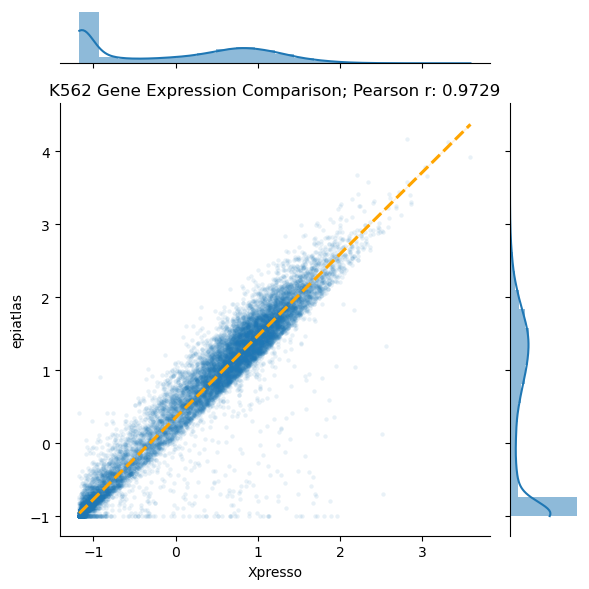

<Figure size 600x600 with 0 Axes>

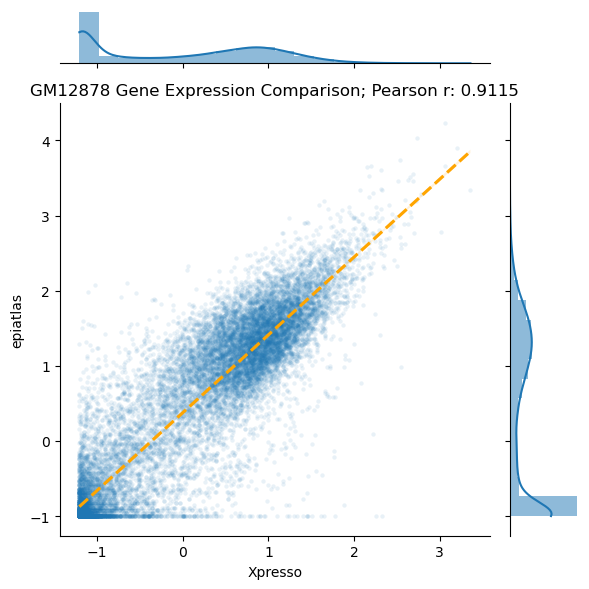

In [7]:
# plot xpresso data gainst the IHEC data
def plot_scatter(expr_data, xlabel, ylabel, title):
    pearsonr = expr_data.corr(method='pearson').iloc[0, 1]
    plt.figure(figsize=(6,6))
    ax = sns.jointplot(
        data=expr_data,
        x="Xpresso",
        y="epiatlas",
        kind = 'scatter',
        joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
        marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
    )
    ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
    ax.ax_joint.set_title(f"{title}; Pearson r: {pearsonr:.4f}")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.tight_layout()

# plot K562
plot_scatter(
    pd.DataFrame({
        'Xpresso': xpresso_df.loc[k562_genes]['Actual_K562'],
        'epiatlas': np.log10(k562_data.loc[k562_genes][expr_column] + 0.1)
    }),
    'Xpresso',
    'epiatlas',
    'K562 Gene Expression Comparison'
)

# plot GM12878
plot_scatter(
    pd.DataFrame({
        'Xpresso': xpresso_df.loc[gm_genes]['Actual_GM12878'],
        'epiatlas': np.log10(gm_12878.loc[gm_genes][expr_column] + 0.1)
    }),
    'Xpresso',
    'epiatlas',
    'GM12878 Gene Expression Comparison'
)

In [10]:
# combine gm and k562 data into one df
expression_data = pd.DataFrame({
    'ENSID': k562_data.index,
    'K562': np.log10(k562_data[expr_column] + 0.1),
    'GM12878': np.log10(gm_12878[expr_column] + 0.1),
})
expression_data = expression_data[expression_data['ENSID'].isin(xpresso_df.index)]
# mean center the data
expression_data['K562'] = expression_data['K562'] - expression_data['K562'].mean()
expression_data['GM12878'] = expression_data['GM12878'] - expression_data['GM12878'].mean()
# save the data
expression_data.to_csv(f'data/GM12878_K562_{len(expression_data)}_gene_expr_epiatlas.csv', index=False)